## isolated clustering including recombination of mini-cluster for hpc run 

Comments:

By using the read weighted edge list from a csv file, it saves much space on self.graph

This will for specific batch number and hop-layer number

In [29]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [30]:
import copy
import csv
import os
import sys
import torch
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm
import pickle
import shutil

from utils import *


In [31]:
import inspect
import torch
from torch_geometric.utils import scatter_

import math
import random

from torch.nn import Parameter
from torch_scatter import scatter_add
# from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import add_remaining_self_loops

### ====================== Establish a GCN based model ========================
class ListModule(torch.nn.Module):
    """
    Abstract list layer class.
    """
    def __init__(self, *args):
        """
        Module initializing.
        """
        super(ListModule, self).__init__()
        idx = 0
        for module in args:
            self.add_module(str(idx), module)
            idx += 1

    def __getitem__(self, idx):
        """
        Getting the indexed layer.
        """
        if idx < 0 or idx >= len(self._modules):
            raise IndexError('index {} is out of range'.format(idx))
        it = iter(self._modules.values())
        for i in range(idx):
            next(it)
        return next(it)

    def __iter__(self):
        """
        Iterating on the layers.
        """
        return iter(self._modules.values())

    def __len__(self):
        """
        Number of layers.
        """
        return len(self._modules)


class Net(torch.nn.Module):
    def __init__(self, in_channels, out_channels, input_layers = [16, 16], dropout=0.3):
        """
        input layers: list of integers
        dropout: probability of droping out 
        """
        super(Net, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.input_layers = input_layers
        self.dropout = dropout
        self.setup_layers()

    def setup_layers(self):
        """
        Creating the layes based on the args.
        """
        self.layers = []
        self.input_layers = [self.in_channels] + self.input_layers + [self.out_channels]
        for i, _ in enumerate(self.input_layers[:-1]):
            self.layers.append(GCNConv(self.input_layers[i],self.input_layers[i+1]))
        self.layers = ListModule(*self.layers)

    # change the dropout positions: 
    def forward(self, edge_index, features):
        if len(self.layers) > 1:
            for i in range(len(self.layers)-1):
                features = F.relu(self.layers[i](features, edge_index))
#                 if i>0:
                features = F.dropout(features, p = self.dropout, training = self.training)
                    
            features = self.layers[len(self.layers)-1](features, edge_index)
        else:
            features = self.layers[0](features, edge_index)    # for a single layer case

        predictions = F.log_softmax(features, dim=1)
        return predictions

### Partition GCN

In [32]:

import metis
import random
import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split
from itertools import chain

class ClusteringMachine(object):
    """
    Clustering the graph, feature set and label. Performed on the CPU side
    """
    def __init__(self, edge_index, features, label, tmp_folder = './tmp/', info_folder = './info/'):
        """
        :param edge_index: COO format of the edge indices.
        :param features: Feature matrix (ndarray).
        :param label: label vector (ndarray).
        :tmp_folder(string): the path of the folder to contain all the clustering information files
        """
        self.features = features
        self.label = label
        self._set_sizes()
        self.edge_index = edge_index
        # store the information folder for memory tracing
        self.tmp_folder = tmp_folder
        self.info_folder = info_folder
        
        tmp = edge_index.t().numpy().tolist()
        self.graph = nx.from_edgelist(tmp)
        
    def _set_sizes(self):
        """
        Setting the feature and class count.
        """
        self.node_count = self.features.shape[0]
        self.feature_count = self.features.shape[1]    # features all always in the columns
        self.label_count = len(np.unique(self.label.numpy()) )
    
    # 1) first use different clustering method, then split each cluster into train, test and validation nodes, split edges
    def split_cluster_nodes_edges(self, test_ratio, validation_ratio, partition_num = 4, batch_num = 2, round_num = 2):
        """
            1) decompose the whole graph into parition_num small mini-clusters, all the mini-cluster relevant use local variables
            2) recombine the mini-clusters into batch_num batches (self.sg_nodes_global)
        """
        mini_cluster_nodes_global = self.metis_clustering(self.graph, partition_num)
        mini_cluster_id = list(mini_cluster_nodes_global.keys())
        
        relative_test_ratio = (test_ratio) / (1 - validation_ratio)
        
        mini_cluster_validation_nodes_global = {}
        mini_cluster_train_nodes_global = {}
        mini_cluster_test_nodes_global = {}
        
        for cluster in mini_cluster_id:
            mini_cluster_model_nodes_global, mini_cluster_validation_nodes_global[cluster] = \
                    train_test_split(mini_cluster_nodes_global[cluster], test_size = validation_ratio)
            mini_cluster_train_nodes_global[cluster], mini_cluster_test_nodes_global[cluster] = \
                    train_test_split(mini_cluster_model_nodes_global, test_size = relative_test_ratio)
            
        #recombine_mini_cluster_for_batch:
        self.sg_nodes_global = {}
        self.sg_validation_nodes_global = {}
        self.sg_train_nodes_global = {}
        self.sg_test_nodes_global = {}
        # keep the info of each cluster:
        self.info_isolate_cluster_size = {}
        self.info_validation_cluster_size = {}
        self.info_train_cluster_size = {}
        self.info_test_cluster_size = {}
        # compute how many elements is inside each batch
        chunck_size = partition_num // batch_num
        for round_id in range(round_num):
            # first shuffle all the mini-cluster ids:
            mini_cluster_order = mini_cluster_id
            random.shuffle(mini_cluster_order)
            combine_group = [mini_cluster_order[i * chunck_size : (i + 1) * chunck_size] for i in range((len(mini_cluster_order) + chunck_size - 1) // chunck_size )]  
            for local_batch_id, group in enumerate(combine_group):
                global_batch_id = round_id * batch_num + local_batch_id
                self.sg_nodes_global[global_batch_id] = list(chain.from_iterable(mini_cluster_nodes_global[cluster_id] for cluster_id in group))
                self.sg_validation_nodes_global[global_batch_id] = list(chain.from_iterable(mini_cluster_validation_nodes_global[cluster_id] for cluster_id in group))
                self.sg_train_nodes_global[global_batch_id] = list(chain.from_iterable(mini_cluster_train_nodes_global[cluster_id] for cluster_id in group))
                self.sg_test_nodes_global[global_batch_id] = list(chain.from_iterable(mini_cluster_test_nodes_global[cluster_id] for cluster_id in group))
        
        for batch in self.sg_nodes_global.keys():
            # record the information of each recombined batch:
            self.info_isolate_cluster_size[batch] = len(self.sg_nodes_global[batch])
            self.info_validation_cluster_size[batch] = len(self.sg_validation_nodes_global[batch])
            self.info_train_cluster_size[batch] = len(self.sg_train_nodes_global[batch])
            self.info_test_cluster_size[batch] = len(self.sg_test_nodes_global[batch])
    
    # just allocate each node to arandom cluster, store the membership inside each dict
    def random_clustering(self, target_nodes, partition_num):
        """
            Random clustering the nodes.
            Input: 
                1) target_nodes: list of node 
                2) partition_num: number of partition to be generated
            Output: 
                1) membership of each node
        """
        # randomly divide into two clusters
        nodes_order = [node for node in target_nodes]
        random.shuffle(nodes_order)
        n = (len(nodes_order) + partition_num - 1) // partition_num
        partition_list = [nodes_order[i * n:(i + 1) * n] for i in range(partition_num)]
#         cluster_membership = {node : i for i, node_list in enumerate(partition_list) for node in node_list}
        cluster_nodes_global = {i : node_list for i, node_list in enumerate(partition_list)}
        
        return cluster_nodes_global

    def metis_clustering(self, target_graph, partition_num):
        """
            Random clustering the nodes.
            Input: 
                1) target_nodes: list of node 
                2) partition_num: number of partition to be generated
            Output: 
                1) membership of each node
        """
        (st, parts) = metis.part_graph(target_graph, partition_num)
        clusters = list(set(parts))
        cluster_nodes_global = defaultdict(list)
        for node, cluster_id in enumerate(parts):
            cluster_nodes_global[cluster_id].append(node)
        return cluster_nodes_global
        
    def mini_batch_generate(self, batch_file_folder, target_seed):
        """
            create the mini-batch focused on the train nodes only, include a total of k layers of neighbors of the original training nodes
            k: number of layers of neighbors for each training node
            fraction: fraction of neighbor nodes in each layer to be considered
            Input:
                1) target_seed: global ids of the nodes for seed to generate the batch
                    usually one of (train_global, test_global_, validation_global)
            Output: all tensors which are gonna be used in the train, forward procedure
                local:
                    1) sg_mini_edges_local
                    2) self.sg_mini_train_edge_weight_local
                    3) self.sg_mini_train_nodes_local
                    4) self.sg_mini_train_features
                    5) self.sg_mini_train_labels
            
        """
        info_batch_node_size = {}
        info_batch_edge_size = {}
                
        for cluster in target_seed.keys():
            batch_subgraph = self.graph.subgraph(self.sg_nodes_global[cluster])
            
             # first select all the overlapping nodes of the train nodes
            mini_nodes_global = sorted(node for node in batch_subgraph.nodes())
            
            # store the global edges
            mini_edges_global = {edge for edge in batch_subgraph.edges()}
            
            # map nodes from global index to local index
            mini_mapper = {node: i for i, node in enumerate(mini_nodes_global)}
            
            # store local index of batch nodes
            mini_nodes_local = [ mini_mapper[global_idx] for global_idx in target_seed[cluster] ]
            
            # store local index of batch edges
            mini_edges_local = \
                           [ [ mini_mapper[edge[0]], mini_mapper[edge[1]] ] for edge in mini_edges_global ] + \
                           [ [ mini_mapper[edge[1]], mini_mapper[edge[0]] ] for edge in mini_edges_global ]
            
            # store local features and lables
            mini_features = self.features[mini_nodes_global,:]
            mini_labels = self.label[mini_nodes_global]
            
            # record information 
            info_batch_node_size[cluster] = len(mini_nodes_global)
            info_batch_edge_size[cluster] = len(mini_edges_local)
            
            mini_nodes_local = torch.LongTensor(mini_nodes_local)
            mini_edges_local = torch.LongTensor(mini_edges_local).t()
            mini_features = torch.FloatTensor(mini_features)
            mini_labels = torch.LongTensor(mini_labels)
            
            minibatch_data = [mini_nodes_local, mini_edges_local, mini_features, mini_labels]
            
            batch_file_name = batch_file_folder + 'batch_' + str(cluster)
            
            # store the batch files
            t0 = time.time()
            with open(batch_file_name, "wb") as fp:
                pickle.dump(minibatch_data, fp)
            store_time = ((time.time() - t0) * 1000)
#             print('*** Generate batch file for # {0:3d} batch, writing the batch file costed {1:.2f} ms ***'.format(cluster, store_time) )
#             print('writing to the path: ', batch_file_name)
            
        return info_batch_node_size, info_batch_edge_size
    
    def save_info_dict(self, data, file_name, target_folder, header = 'key, value'):
        # output the batch size information as the csv file
        os.makedirs(os.path.dirname(target_folder), exist_ok=True)
        target_file = target_folder + file_name
        
        with open(target_file, 'a', newline='\n') as fp:
            wr = csv.writer(fp, delimiter = ',')
            fp.write('\n')
            wr.writerow(header.split(','))
            for key, val in data.items():
                wr.writerow([key+1, val])
    
    def mini_batch_train_clustering(self, batch_folder, train_batch_num = 2):
        data_type = 'train'
        batch_file_folder = batch_folder + data_type + '/'
        check_folder_exist(batch_file_folder)
        os.makedirs(os.path.dirname(batch_file_folder), exist_ok=True)
        
        self.info_train_batch_node_size, self.info_train_batch_edge_size  = self.mini_batch_generate(batch_file_folder, self.sg_train_nodes_global)
        self.info_train_seed_size = {key : len(val) for key, val in self.sg_train_nodes_global.items()}
        
        self.save_info_dict(self.info_train_batch_node_size, 'batch_size_info.csv', self.info_folder, header = 'train_batch_node_id, train_batch_node_size')
        self.save_info_dict(self.info_train_batch_edge_size, 'batch_size_info.csv', self.info_folder, header = 'train_batch_edge_id, train_batch_edge_size')
        self.save_info_dict(self.info_train_seed_size, 'batch_size_info.csv', self.info_folder, header = 'train_seed_node_id, train_seed_node_size')
        
    def mini_batch_validation_clustering(self, batch_folder, valid_batch_num = 2):
        data_type = 'validation'
        batch_file_folder = batch_folder + data_type + '/'
        check_folder_exist(batch_file_folder)
        os.makedirs(os.path.dirname(batch_file_folder), exist_ok=True)

        self.info_validation_batch_node_size, self.info_validation_batch_edge_size = self.mini_batch_generate(batch_file_folder, self.sg_validation_nodes_global)
        self.info_validation_seed_size = {key : len(val) for key, val in self.sg_validation_nodes_global.items()}
        
        self.save_info_dict(self.info_validation_batch_node_size, 'batch_size_info.csv', self.info_folder, header = 'validation_batch_node_id, validation_batch_node_size')
        self.save_info_dict(self.info_validation_batch_edge_size, 'batch_size_info.csv', self.info_folder, header = 'validation_batch_edge_id, validation_batch_edge_size')
        self.save_info_dict(self.info_validation_seed_size, 'batch_size_info.csv', self.info_folder, header = 'validation_seed_node_id, validation_seed_node_size')
        
    def mini_batch_test_clustering(self, batch_folder, test_batch_num = 2):
        data_type = 'test'
        batch_file_folder = batch_folder + data_type + '/'
        check_folder_exist(batch_file_folder)
        os.makedirs(os.path.dirname(batch_file_folder), exist_ok=True)
        
        self.info_test_batch_node_size, self.info_test_batch_edge_size = self.mini_batch_generate(batch_file_folder, self.sg_test_nodes_global)
        self.info_test_seed_size = {key : len(val) for key, val in self.sg_test_nodes_global.items()}
        self.save_info_dict(self.info_test_batch_node_size, 'batch_size_info.csv', self.info_folder, header = 'test_batch_node_id, test_batch_node_size')
        

#### Partition Graph with trainiing and testing

In [33]:
# from Custom_GCN_layer import Net
import time
from torch.autograd import Variable
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

class ClusterGCNTrainer_mini_Train(object):
    """
    Training a ClusterGCN.
    """
    def __init__(self, data_folder, in_channels, out_channels, input_layers = [32, 16], dropout=0.3):
        """
        :param in_channels, out_channels: input and output feature dimension
        :param clustering_machine:
        """  
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.data_folder = data_folder
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.input_layers = input_layers
        self.dropout = dropout
        
        self.create_model()

    def create_model(self):
        """
        Creating a StackedGCN and transferring to CPU/GPU.
        """
#         print('used layers are: ', str(self.input_layers))
        self.model = Net(self.in_channels, self.out_channels, input_layers = self.input_layers, dropout = self.dropout)
        self.model = self.model.to(self.device)
    
    # call the forward function batch by batch
    def do_forward_pass(self, tr_train_nodes, tr_edges, tr_features, tr_target):
        """
        Making a forward pass with data from a given partition.
        :param cluster: Cluster index.
        :return average_loss: Average loss on the cluster.
        :return node_count: Number of nodes.
        """
        
        '''Target and features are one-one mapping'''
        # calculate the probabilites from log_sofmax
        predictions = self.model(tr_edges, tr_features)
        
        ave_loss = torch.nn.functional.nll_loss(predictions[tr_train_nodes], tr_target[tr_train_nodes])
        node_count = tr_train_nodes.shape[0]

        # for each cluster keep track of the counts of the nodes
        return ave_loss, node_count

    def update_average_loss(self, batch_average_loss, node_count, isolate = True):
        """
        Updating the average loss in the epoch.
        :param batch_average_loss: Loss of the cluster. 
        :param node_count: Number of nodes in currently processed cluster.
        :return average_loss: Average loss in the epoch.
        """
        self.accumulated_training_loss = self.accumulated_training_loss + batch_average_loss.item() * node_count
        if isolate:
            self.node_count_seen = self.node_count_seen + node_count
        average_loss = self.accumulated_training_loss / self.node_count_seen
        return average_loss

    # iterate through epoch and also the clusters
    def train_investigate_F1(self, epoch_num=10, learning_rate=0.01, weight_decay = 0.01, mini_epoch_num = 1, output_period = 10, train_batch_num = 2, valid_batch_num = 2):
        """
            *** Periodically output the F1 score during training. After certain number of epochs ***
            epoch_num:  number of total training epoch number
            learning rate: learning rate during training
            weight_decay:  decay coefficients for the regularization
            mini_epoch_num:  number of epochs of repeating training after loading data on the GPU
            output_period:  number of epochs after which output the F1 and accuray to investigate the model refining process
        """
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        self.model.train()   #   set into train mode, only effective for certain modules such as dropout and batchNorm
        self.record_ave_training_loss = []
        self.time_train_load_data = 0
        
        epoch_partition = epoch_num // mini_epoch_num
        investigate_f1 = {}
        investigate_accuracy = {}
        
        t0 = time.time()
        train_clusters = list(range(train_batch_num))
        for epoch_part in range(epoch_partition):
#             For test purpose, we let the clusters to follow specific order
            random.shuffle(train_clusters)
            self.node_count_seen = 0
            self.accumulated_training_loss = 0
            for cluster in train_clusters:
                # for each batch, we load once and train it for multiple epochs:
                # read in the train data from the pickle files
                batch_file_name = self.data_folder + 'train/batch_' + str(cluster)
                
                t2 = time.time()
                with open(batch_file_name, "rb") as fp:
                    minibatch_data_train = pickle.load(fp)
                read_time = (time.time() - t2) * 1000
#                 print('*** During training for # {0:3d} batch, reading batch file costed {1:.2f} ms ***'.format(cluster, read_time) )
                
                tr_train_nodes, tr_edges, tr_features, tr_target = minibatch_data_train
                
                t1 = time.time()
                tr_train_nodes = tr_train_nodes.to(self.device)
                tr_edges = tr_edges.to(self.device)
                tr_features = tr_features.to(self.device)
                tr_target = tr_target.to(self.device)
                
                self.time_train_load_data += (time.time() - t1) * 1000
                # train each batch for multiple epochs
                for mini_epoch in range(mini_epoch_num):
                    # record the current overall epoch index:
                    real_epoch_num = 1 + mini_epoch + mini_epoch_num * epoch_part # real_epoch_num starts from 0, therefore we add 1
                    
                    self.optimizer.zero_grad()
                    batch_ave_loss, node_count = self.do_forward_pass(tr_train_nodes, tr_edges, tr_features, tr_target)
                    batch_ave_loss.backward()
                    self.optimizer.step()
                    ave_loss = self.update_average_loss(batch_ave_loss, node_count)
                    
                    # at this point finish a single train duration: update the parameter and calcualte the loss function
                    # periodically output the F1-score in the middle of the training process
                    if real_epoch_num % output_period == 0:
                        investigate_f1[real_epoch_num], investigate_accuracy[real_epoch_num] = self.batch_validate(valid_batch_num = valid_batch_num)
                        self.model.train()    # reset to the train mode
            
            self.record_ave_training_loss.append(ave_loss)
        # convert to ms
        self.time_train_total = ((time.time() - t0) * 1000)
        return investigate_f1, investigate_accuracy

    # iterate through epoch and also the clusters
    def train(self, epoch_num=10, learning_rate=0.01, weight_decay = 0.01, mini_epoch_num = 1, train_batch_num = 2):
        """
            *** Training a model. ***
            epoch_num:  number of total training epoch number
            learning rate: learning rate during training
            weight_decay:  decay coefficients for the regularization
            mini_epoch_num:  number of epochs of repeating training after loading data on the GPU
        """
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        self.model.train()
        self.record_ave_training_loss = []
        self.time_train_load_data = 0
        
        epoch_partition = epoch_num // mini_epoch_num
        t0 = time.time()
        train_clusters = list(range(train_batch_num))
        for epoch in range(epoch_partition):
#             For test purpose, we let the clusters to follow specific order
            random.shuffle(train_clusters)
            self.node_count_seen = 0
            self.accumulated_training_loss = 0
            
            for cluster in train_clusters:
                # read in the train data from the pickle files
                batch_file_name = self.data_folder + 'train/batch_' + str(cluster)
                
                t2 = time.time()
                with open(batch_file_name, "rb") as fp:
                    minibatch_data_train = pickle.load(fp)
                read_time = (time.time() - t2) * 1000
#                 print('*** During training for # {0:3d} batch, reading batch file costed {1:.2f} ms ***'.format(cluster, read_time) )
                
                tr_train_nodes, tr_edges, tr_features, tr_target = minibatch_data_train
                
                # for each cluster, we load once and train it for multiple epochs:
                t1 = time.time()
                tr_train_nodes = tr_train_nodes.to(self.device)
                tr_edges = tr_edges.to(self.device)
                tr_features = tr_features.to(self.device)
                tr_target = tr_target.to(self.device)
                
                self.time_train_load_data += (time.time() - t1) * 1000
                # train each batch for multiple epochs
                for mini_epoch in range(mini_epoch_num):
                    self.optimizer.zero_grad()
                    batch_ave_loss, node_count = self.do_forward_pass(tr_train_nodes, tr_edges, tr_features, tr_target)
                    batch_ave_loss.backward()
                    self.optimizer.step()
                    ave_loss = self.update_average_loss(batch_ave_loss, node_count)
            
            self.record_ave_training_loss.append(ave_loss)
        # convert to ms
        self.time_train_total = ((time.time() - t0) * 1000)
    

    def do_batch_validation_prediction(self, valid_validation_nodes, valid_edges, valid_features, valid_target):
        """
        Scoring a cluster.
        :param cluster: Cluster index.
        :return prediction: Prediction matrix with probabilities.
        :return target: Target vector.
        """
        predictions = self.model(valid_edges, valid_features)
        return predictions[valid_validation_nodes], valid_target[valid_validation_nodes]

    def batch_validate(self, valid_batch_num = 2):
        """
        Scoring the test and printing the F-1 score.
        """
        self.model.eval()   # set into test mode, only effective for certain modules such as dropout and batchNorm
        
        predictions = []
        targets = []
        valid_clusters = list(range(valid_batch_num))
        for cluster in valid_clusters:
            # read in the train data from the pickle files
            batch_file_name = self.data_folder + 'validation/batch_' + str(cluster)
            
            t2 = time.time()
            with open(batch_file_name, "rb") as fp:
                minibatch_data_validation = pickle.load(fp)
            read_time = (time.time() - t2) * 1000
#             print('*** During validation for # {0:3d} batch, reading batch file costed {1:.2f} ms ***'.format(cluster, read_time) )

            valid_validation_nodes, valid_edges, valid_features, valid_target = minibatch_data_validation
            
            valid_validation_nodes = valid_validation_nodes.to(self.device)
            valid_edges = valid_edges.to(self.device)
            valid_features = valid_features.to(self.device)
            valid_target = valid_target.to(self.device)
            
            
            prediction, target = self.do_batch_validation_prediction(valid_validation_nodes, valid_edges, valid_features, valid_target)

            predictions.append(prediction.cpu().detach().numpy())
            targets.append(target.cpu().detach().numpy())
        
        # concatenate all the ndarrays inside this list
        targets = np.concatenate(targets)
        # along axis:    axis == 1
        predictions = np.concatenate(predictions).argmax(1)  # return the indices of maximum probability 
#         print('shape of the targets and predictions are: ', self.targets.shape, self.predictions.shape)
        
        f1 = f1_score(targets, predictions, average="micro")
        accuracy = accuracy_score(targets, predictions)
#         print("\nTest F-1 score: {:.4f}".format(score))
        return (f1, accuracy)

# for cross-validation purpose: 
    def do_prediction(self, cluster):
        """
        Scoring a cluster.
        :param cluster: Cluster index.
        :return prediction: Prediction matrix with probabilities.
        :return target: Target vector.
        """
        test_nodes = self.clustering_machine.sg_test_nodes_global[cluster].to(self.device)
        prediction = self.model(self.edges, self.features, self.edge_weights)
        
        return prediction[test_nodes], self.label[test_nodes]
    
    def test(self):
        """
        Scoring the test and printing the F-1 score.
        """
        self.model.eval()
        self.predictions = []
        self.targets = []
        
        self.edges = self.clustering_machine.edge_index_global_self_loops.to(self.device)
        self.features = self.clustering_machine.features.to(self.device)
        self.edge_weights = self.clustering_machine.edge_weight_global.to(self.device)
        self.label = self.clustering_machine.label.to(self.device)
        
        for cluster in self.clustering_machine.test_clusters:
            prediction, target = self.do_prediction(cluster)

            self.predictions.append(prediction.cpu().detach().numpy())
            self.targets.append(target.cpu().detach().numpy())
        
        # concatenate all the ndarrays inside this list
        self.targets = np.concatenate(self.targets)
        # along axis:    axis == 1
        self.predictions = np.concatenate(self.predictions).argmax(1)  # return the indices of maximum probability 
#         print('shape of the targets and predictions are: ', self.targets.shape, self.predictions.shape)
        
        f1 = f1_score(self.targets, self.predictions, average="micro")
        accuracy = accuracy_score(self.targets, self.predictions)
#         print("\nTest F-1 score: {:.4f}".format(score))
        return (f1, accuracy)



### Use Trivial data

In [34]:
'''Trivial data'''
edge_index = torch.tensor([[0, 1, 1, 3, 1, 2, 4, 2, 4, 6, 6, 7, 7, 9, 2, 5, 9, 8], 
                           [1, 0, 3, 1, 2, 1, 2, 4, 6, 4, 7, 6, 9, 7, 5, 2, 8, 9]])
# features = torch.rand(10, 3)
features = torch.tensor([[0, 0], [0, 1], [0, 2], [0, 3], [0, 4],  
                           [0, 5], [0, 6], [0, 7], [0, 8], [0, 9]], dtype = torch.float)
# label = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
label = torch.tensor([0, 1, 1, 0, 1, 1, 1, 0, 0, 0])
print(features, features.shape)

# set the tmp folder
# tmp_folder = './tmp/'
# check_folder_exist(tmp_folder)
# os.makedirs(os.path.dirname(tmp_folder), exist_ok=True)
# set the store clustering path
clustering_folder = './res_save_batch/clustering/'
check_folder_exist(clustering_folder)
clustering_file_name = clustering_folder + 'check_clustering_machine.txt'
os.makedirs(os.path.dirname(clustering_file_name), exist_ok=True)

node_count = features.shape[0]
clustering_machine = ClusteringMachine(edge_index, features, label)
clustering_machine.split_cluster_nodes_edges(0.4, 0.4, partition_num = 2)

with open(clustering_file_name, "wb") as fp:
    pickle.dump(clustering_machine, fp)

tensor([[0., 0.],
        [0., 1.],
        [0., 2.],
        [0., 3.],
        [0., 4.],
        [0., 5.],
        [0., 6.],
        [0., 7.],
        [0., 8.],
        [0., 9.]]) torch.Size([10, 2])


### minibatch train nodes and batch validatioin 

In [35]:

mini_batch_folder = './res_save_batch/mini_batch_files/'
check_folder_exist(mini_batch_folder)

with open(clustering_file_name, "rb") as fp:
    clustering_machine = pickle.load(fp)

# generate the batches for train and validation
clustering_machine.mini_batch_train_clustering(mini_batch_folder, train_batch_num = 2) # include number of layers

clustering_machine.mini_batch_validation_clustering(mini_batch_folder, valid_batch_num = 2)

# construct the batch trainer
gcn_trainer_batch = ClusterGCNTrainer_mini_Train(mini_batch_folder, 2, 2, input_layers = [16], dropout=0.3)

gcn_trainer_batch.train(1, 0.0001, 0.1, train_batch_num = 2)
gcn_trainer_batch.batch_validate(valid_batch_num = 2)

(0.5, 0.5)

### Check the train loss 

In [36]:
def check_train_loss_converge(mini_batch_folder, data_name, dataset, image_path,  comments, input_layer = [32, 16], epoch_num = 300, \
                              dropout = 0.3, lr = 0.0001, weight_decay = 0.01, mini_epoch_num = 5, \
                               valid_part_num = 2, train_part_num = 2, test_part_num = 1):
    # mini-batch, but valid also in batches
    Trainer_folder = mini_batch_folder + 'GCNtrainer/'
    check_folder_exist(Trainer_folder)
    os.makedirs(os.path.dirname(Trainer_folder), exist_ok=True)
    
    trainer_id = 0
    Cluster_train_batch_run(trainer_id, mini_batch_folder, data_name, dataset, image_path, input_layer = input_layer, epochs=epoch_num, \
                                                                               dropout = dropout, lr = lr, weight_decay = weight_decay, mini_epoch_num = mini_epoch_num, \
                                                                               train_part_num = train_part_num, test_part_num = test_part_num)
    trainer_file_name = mini_batch_folder + 'GCNtrainer/GCN_trainer_' + str(trainer_id)
    with open(trainer_file_name, "rb") as fp:
        Cluster_train_batch_trainer = pickle.load(fp)
    
    draw_Cluster_train_valid_batch = draw_trainer_info(data_name, Cluster_train_batch_trainer, image_path, 'train_valid_batch_' + comments)
    draw_Cluster_train_valid_batch.draw_ave_loss_per_node()
    

''' Draw the information about the GCN calculating batch size '''
def draw_cluster_info(clustering_machine, data_name, img_path, comments = '_cluster_node_distr'):
    """
        Won't call this for mini-batch with no clustering 
    """
    cluster_id = clustering_machine.train_clusters    # a list of cluster indices
    cluster_datapoints = {'cluster_id': cluster_id,  \
                          'train_batch' : [clustering_machine.info_train_batch_size[idx] for idx in cluster_id], \
                          'cluster_size' : [clustering_machine.info_isolate_cluster_size[idx] for idx in cluster_id], \
                         }
                         
    df = pd.DataFrame(data=cluster_datapoints, dtype=np.int32)
    # print(df)
    df_reshape = df.melt('cluster_id', var_name = 'clusters', value_name = 'node_num')
    
    plt.clf()
    plt.figure()
    sns.set(style='whitegrid')
    g = sns.catplot(x="cluster_id", y="node_num", hue='clusters', kind='bar', data=df_reshape)
    g.despine(left=True)
    g.fig.suptitle(data_name + comments)
    g.set_xlabels("Cluster ID")
    g.set_ylabels("Number of nodes")
    
    img_name = img_path + data_name + comments
    os.makedirs(os.path.dirname(img_name), exist_ok=True)
    g.savefig(img_name, bbox_inches='tight')

### Specific model run

In [37]:
''' Execute the testing program '''
def set_clustering_machine(data, image_path, intermediate_data_folder, test_ratio = 0.05, validation_ratio = 0.85, train_part_num = 2, mini_cluster_num = 16, round_num = 2):
    """
        Set the batch machine plus generate the training batches
            1) data: the target dataset data
            2) intermediate_data_folder: path to store the intermediate generated data
            3) test_ratio, validation_ratio: data split ratio
            4) neigh_layer: number of hops (layers) for the neighbor nodes 
            5) train_frac: each time including fraction of the neigbor nodes in each layer
            6) valid_part_num, train_part_num, test_part_num :  batch number for validation, train and test data correspondingly
    """
    # set the tmp file for garbage tmp files, just collect the info:
    tmp_folder = './tmp/'
    check_folder_exist(tmp_folder)
    os.makedirs(os.path.dirname(tmp_folder), exist_ok=True)
    
    # Set the clustering information storing path
    clustering_file_folder = intermediate_data_folder + 'clustering/'
    check_folder_exist(clustering_file_folder)  # if exist then delete
    clustering_file_name = clustering_file_folder + 'clustering_machine.txt'
    os.makedirs(os.path.dirname(clustering_file_folder), exist_ok=True)
    
    # if we use the random assignment of the code, then filtering out the isolated data may not be necessary
#     connect_edge_index, connect_features, connect_label = filter_out_isolate(data.edge_index, data.x, data.y)
#     clustering_machine = ClusteringMachine(connect_edge_index, connect_features, connect_label)
    print('\n' + '=' * 100)
    print('Start to generate the clustering machine:')
    t0 = time.time()
    clustering_machine = ClusteringMachine(data.edge_index, data.x, data.y, tmp_folder, info_folder = image_path)
    batch_machine_create = time.time() - t0
    print('Batch machine creation costs a total of {0:.4f} seconds!'.format(batch_machine_create))
    
    # at last output the information inside the folder:
    print_dir_content_info(tmp_folder)
    
#     clustering_machine.split_cluster_nodes_edges(test_ratio, validation_ratio, partition_num = train_part_num)
    # mini-batch only: split to train test valid before clustering
    print('Start to split data into train, test, validation:')
    t1 = time.time()
    clustering_machine.split_cluster_nodes_edges(test_ratio, validation_ratio, partition_num = mini_cluster_num, batch_num = train_part_num, round_num = round_num)
    data_split_time = time.time() - t1
    print('Data splitting costs a total of {0:.4f} seconds!'.format(data_split_time))
    
    print('Start to store the batch machine file:')
    t3 = time.time()
    with open(clustering_file_name, "wb") as fp:
        pickle.dump(clustering_machine, fp)
    batch_machine_store_time = time.time() - t3
    print('Storing batch machine after training batches generation costs a total of {0:.4f} seconds!'.format(batch_machine_store_time))
    print('\n' + '=' * 100)
    # output the memory usage information
    output_GPU_memory_usage('Memory_use_setting_cluster.txt', image_path, comment ='after setting clustering machine: ')
    
def set_clustering_machine_train_batch(image_path, intermediate_data_folder, train_part_num = 2):
    """
        Generate the train batches
    """
    clustering_file_folder = intermediate_data_folder + 'clustering/'
    clustering_file_name = clustering_file_folder + 'clustering_machine.txt'
    print('\n' + '=' * 100)
    
    t0 = time.time()
    with open(clustering_file_name, "rb") as fp:
        clustering_machine = pickle.load(fp)
    batch_machine_read = time.time() - t0
    print('Batch machine reading costs a total of {0:.4f} seconds!'.format(batch_machine_read))
    
    mini_batch_folder = intermediate_data_folder
#     check_folder_exist(mini_batch_folder)  # if exist then delete
    print('Start to generate the training batches:')
    t2 = time.time()
    clustering_machine.mini_batch_train_clustering(mini_batch_folder, train_batch_num = train_part_num)
    train_batch_production_time = time.time() - t2
    print('Train batches production costs a total of {0:.4f} seconds!'.format(train_batch_production_time))
    print_dir_content_info(mini_batch_folder + 'train/')
    print('=' * 100)

def set_clustering_machine_validation_batch(image_path, intermediate_data_folder, valid_part_num = 2):
    """
        Generate the validation batches
    """
    clustering_file_folder = intermediate_data_folder + 'clustering/'
    clustering_file_name = clustering_file_folder + 'clustering_machine.txt'
    print('\n' + '=' * 100)
    
    t0 = time.time()
    with open(clustering_file_name, "rb") as fp:
        clustering_machine = pickle.load(fp)
    batch_machine_read = time.time() - t0
    print('Batch machine reading costs a total of {0:.4f} seconds!'.format(batch_machine_read))
    
    print('Start to generate the validation batches:')
    mini_batch_folder = intermediate_data_folder
    t1 = time.time()
    # for validation , fraction has to be 1.0 so that to include the information form original graph
    clustering_machine.mini_batch_validation_clustering(mini_batch_folder, valid_batch_num = valid_part_num)
    validation_batch_production_time = time.time() - t1
    print('Validation batches production costs a total of {0:.4f} seconds!'.format(validation_batch_production_time))
    print_dir_content_info(mini_batch_folder + 'validation/')
    print('=' * 100)
    # output the memory usage information
    output_GPU_memory_usage('Memory_use_setting_cluster.txt', image_path, comment ='after generating validation batches: ')

def Cluster_train_batch_run(trainer_id, mini_batch_folder, data_name, dataset, image_path, input_layer = [16, 16], epochs=300, \
                           dropout = 0.3, lr = 0.01, weight_decay = 0.01, mini_epoch_num = 5, \
                                 train_part_num = 2, test_part_num = 1):
    """
    # Run the mini-batch model (train and validate both in batches)
    Tuning parameters:  dropout, lr (learning rate), weight_decay: l2 regularization
    return: validation accuracy value, validation F-1 value, time_training (ms), time_data_load (ms)
    """
#     print('\n' + '=' * 100)
#     print('Start generate the trainer:')
    t0 = time.time()
    gcn_trainer = ClusterGCNTrainer_mini_Train(mini_batch_folder, dataset.num_node_features, dataset.num_classes, input_layers = input_layer, dropout = dropout)
    train_create = time.time() - t0
#     print('Trainer creation costs a total of {0:.4f} seconds!'.format(train_create))
    
#     print('Start train the model:')
    t1 = time.time()
    gcn_trainer.train(epoch_num=epochs, learning_rate=lr, weight_decay=weight_decay, mini_epoch_num = mini_epoch_num, train_batch_num = train_part_num)
    train_period = time.time() - t1
#     print('Training costs a total of {0:.4f} seconds!'.format(train_period))
    
#     print('Start to save the GCN trainer model (parameters: weights, bias):')
    trainer_file_name = mini_batch_folder + 'GCNtrainer/GCN_trainer_' + str(trainer_id)
    t2 = time.time()
    with open(trainer_file_name, "wb") as fp:
        pickle.dump(gcn_trainer, fp)
    store_trainer = time.time() - t2
#     print('Storing the trainer costs a total of {0:.4f} seconds!'.format(store_trainer))
#     print('-' * 80)
    output_GPU_memory_usage('Memory_use_batch_train.txt', image_path, comment ='after generating trainer and train minibatches: ')

def Cluster_valid_batch_run(trainer_id, mini_batch_folder, data_name, dataset, image_path, input_layer = [16, 16], epochs=300, \
                           dropout = 0.3, lr = 0.01, weight_decay = 0.01, mini_epoch_num = 5, \
                                 valid_part_num = 2):
#     print('Start to read the GCN trainer model (parameters: weights, bias):')
    trainer_file_name = mini_batch_folder + 'GCNtrainer/GCN_trainer_' + str(trainer_id)
    t1 = time.time()
    with open(trainer_file_name, "rb") as fp:
        gcn_trainer = pickle.load(fp)
    read_trainer = (time.time() - t1) * 1000
#     print('Reading the trainer costs a total of {0:.4f} seconds!'.format(read_trainer))
    
#     print('Start validate the model:')
    t2 = time.time()
    validation_F1, validation_accuracy = gcn_trainer.batch_validate(valid_batch_num = valid_part_num)
    validation_period = time.time() - t2
#     print('Validatoin costs a total of {0:.4f} seconds!'.format(validation_period))
#     print('Finish train and validate the model:')
#     print('=' * 100)
    time_train_total = gcn_trainer.time_train_total
    time_data_load = gcn_trainer.time_train_load_data
    
    output_GPU_memory_usage('Memory_use_batch_validation.txt', image_path, comment ='after validating minibatches: ')
    
    return validation_accuracy, validation_F1, time_train_total, time_data_load


def Cluster_train_valid_batch_investigate(mini_batch_folder, data_name, dataset, image_path, input_layer = [16, 16], epochs=300, \
                           dropout = 0.3, lr = 0.01, weight_decay = 0.01, mini_epoch_num = 5, output_period = 10, 
                                         valid_part_num = 2, train_part_num = 2, test_part_num = 1):
    """
        *** dynamically investigate the F1 score in the middle of the training after certain period ***
        output: two dict containing F1-score and accuracy of a certain epoch index
    """
#     print('\n' + '=' * 100)
#     print('Start generate the trainer:')
    t0 = time.time()
    gcn_trainer = ClusterGCNTrainer_mini_Train(mini_batch_folder, dataset.num_node_features, dataset.num_classes, input_layers = input_layer, dropout = dropout)
    train_create = time.time() - t0
#     print('Trainer creation costs a total of {0:.4f} seconds!'.format(train_create))
    
#     print('Start train the model:')
    t1 = time.time()
    Train_period_F1, Train_period_accuracy = gcn_trainer.train_investigate_F1(epoch_num=epochs, learning_rate=lr, weight_decay=weight_decay, mini_epoch_num = mini_epoch_num, \
                                                            output_period = output_period, train_batch_num = train_part_num, valid_batch_num = valid_part_num)
    train_period = time.time() - t1
    print('In-process Training costs a total of {0:.4f} seconds!'.format(train_period))
#     print('=' * 100)
    output_GPU_memory_usage('Memory_use_investigate_batch_train_valid.txt', image_path, comment ='after train_validation investigate batches  minibatches: ')
    return Train_period_F1, Train_period_accuracy

# for the purpose for tuning 
def Cluster_train_valid_batch_run(mini_batch_folder, data_name, dataset, image_path, input_layer = [16, 16], epochs=300, \
                           dropout = 0.3, lr = 0.01, weight_decay = 0.01, mini_epoch_num = 5, \
                                 valid_part_num = 2, train_part_num = 2, test_part_num = 1):
    """
    # Run the mini-batch model (train and validate both in batches)
    Tuning parameters:  dropout, lr (learning rate), weight_decay: l2 regularization
    return: validation accuracy value, validation F-1 value, time_training (ms), time_data_load (ms)
    """
#     gcn_trainer_batch = ClusterGCNTrainer_mini_Train(mini_batch_folder, 2, 2, 2, 2, 2, input_layers = [16], dropout=0.3)
#     print('\n' + '=' * 100)
#     print('Start generate the trainer:')
    t0 = time.time()
    gcn_trainer = ClusterGCNTrainer_mini_Train(mini_batch_folder, dataset.num_node_features, dataset.num_classes, input_layers = input_layer, dropout = dropout)
    train_create = time.time() - t0
#     print('Trainer creation costs a total of {0:.4f} seconds!'.format(train_create))
    
#     print('Start train the model:')
    t1 = time.time()
    gcn_trainer.train(epoch_num=epochs, learning_rate=lr, weight_decay=weight_decay, mini_epoch_num = mini_epoch_num, train_batch_num = train_part_num)
    train_period = time.time() - t1
#     print('Training costs a total of {0:.4f} seconds!'.format(train_period))
#     print('-' * 80)
    
#     print('Start validate the model:')
    t2 = time.time()
    validation_F1, validation_accuracy = gcn_trainer.batch_validate(valid_batch_num = valid_part_num)
    validation_period = time.time() - t2
#     print('Validatoin costs a total of {0:.4f} seconds!'.format(validation_period))
#     print('=' * 100)
    time_train_total = gcn_trainer.time_train_total
    time_data_load = gcn_trainer.time_train_load_data
    output_GPU_memory_usage('Memory_use_train_validation_together.txt', image_path, comment ='after train_validation batches  minibatches together: ')
    return validation_accuracy, validation_F1, time_train_total, time_data_load

### Test and compare different models

In [38]:
def execute_one_train(mini_batch_folder, image_path, repeate_time = 5, input_layer = [32], epoch_num = 300, \
                dropout = 0.3, lr = 0.0001, weight_decay = 0.01, mini_epoch_num = 5, \
                train_part_num = 2, test_part_num = 1):
    """
        Perform one train and store the results for all trainer
    """
    Trainer_folder = mini_batch_folder + 'GCNtrainer/'
    check_folder_exist(Trainer_folder)
    os.makedirs(os.path.dirname(Trainer_folder), exist_ok=True)
#     graph_model = ['batch_valid', 'train_batch', 'whole_graph', 'isolate']
    for trainer_id in range(repeate_time):
        model_res = []
        
        Cluster_train_batch_run(trainer_id, mini_batch_folder, data_name, dataset, image_path, input_layer = input_layer, epochs=epoch_num, \
                                                         dropout = dropout, lr = lr, weight_decay = weight_decay, mini_epoch_num = mini_epoch_num, \
                                                         train_part_num = train_part_num, test_part_num = test_part_num)
        
def execute_one_validation(mini_batch_folder, image_path, repeate_time = 5, input_layer = [32], epoch_num = 300, \
                dropout = 0.3, lr = 0.0001, weight_decay = 0.01, mini_epoch_num = 5, \
                valid_part_num = 2):
    """
        return all test-F1 and validation-F1 for all four models
    """
    validation_accuracy = {}
    validation_f1 = {}
    time_total_train = {}
    time_data_load = {}
    
    # Each graph model corresponds to one function below
#     graph_model = ['batch_valid', 'train_batch', 'whole_graph', 'isolate']
    graph_model = ['batch_valid']
    for trainer_id in range(repeate_time):
        model_res = []
        model_res.append(Cluster_valid_batch_run(trainer_id, mini_batch_folder, data_name, dataset, image_path, input_layer = input_layer, epochs=epoch_num, \
                                                         dropout = dropout, lr = lr, weight_decay = weight_decay, mini_epoch_num = mini_epoch_num, \
                                                      valid_part_num = valid_part_num)[:4])
        
        validation_accuracy[trainer_id], validation_f1[trainer_id], time_total_train[trainer_id], time_data_load[trainer_id] = zip(*model_res)
    return graph_model, validation_accuracy, validation_f1, time_total_train, time_data_load

def store_data_multi_tests(f1_data, data_name, graph_model, img_path, comments):
    run_id = sorted(f1_data.keys())
    run_data = {'run_id': run_id}
    
    run_data.update({model_name : [f1_data[key][idx] for key in run_id] for idx, model_name in enumerate(graph_model)})
    
    pickle_filename = img_path + data_name + '_' + comments + '.pkl'
    os.makedirs(os.path.dirname(pickle_filename), exist_ok=True)
    df = pd.DataFrame(data=run_data, dtype=np.int32)
    df.to_pickle(pickle_filename)
    return pickle_filename

def draw_data_multi_tests(pickle_filename, data_name, comments, xlabel, ylabel):
    df = pd.read_pickle(pickle_filename)
    df_reshape = df.melt('run_id', var_name = 'model', value_name = ylabel)

    plt.clf()
    plt.figure()
    sns.set(style='whitegrid')
    g = sns.catplot(x="model", y=ylabel, kind='box', data=df_reshape)
    g.despine(left=True)
    g.fig.suptitle(data_name + ' ' + ylabel + ' ' + comments)
    g.set_xlabels(xlabel)
    g.set_ylabels(ylabel)

    img_name = pickle_filename[:-4] + '_img'
    os.makedirs(os.path.dirname(img_name), exist_ok=True)
    plt.savefig(img_name, bbox_inches='tight')
    
    

### Investigate performance in the middle of the training process

In [39]:
def execute_investigate(mini_batch_folder, image_path, repeate_time = 5, input_layer = [32], epoch_num = 300, \
                        dropout = 0.3, lr = 0.0001, weight_decay = 0.01, mini_epoch_num = 5, output_period = 10, \
                         valid_part_num = 2, train_part_num = 2, test_part_num = 1):
    """
        return all test-F1 and validation-F1 for all four models
    """
    
    Train_peroid_f1 = {}
    Train_peroid_accuracy = {}
    
    for i in range(repeate_time):
        Train_peroid_f1[i], Train_peroid_accuracy[i] = Cluster_train_valid_batch_investigate(mini_batch_folder, data_name, dataset, image_path, input_layer = input_layer, epochs=epoch_num, \
                                            dropout = dropout, lr = lr, weight_decay = weight_decay, mini_epoch_num = mini_epoch_num, output_period = output_period, \
                                                                    valid_part_num = valid_part_num, train_part_num = train_part_num, test_part_num = test_part_num)
        
    return Train_peroid_f1, Train_peroid_accuracy

def store_data_multi_investigate(investigate_res, data_name, res_name, img_path, comments):
    """
        investigate_res: currently either F1-score or accuracy a dict {epoch num : value}
    """
    run_id = sorted(investigate_res.keys())
    run_data = {'run_id': run_id}
    
    epoch_num_range = sorted(investigate_res[0].keys())  # at least one entry exists inside the dictionary and the epoch range is fixed
    run_data.update({epoch_num : [investigate_res[key][epoch_num] for key in run_id] for epoch_num in epoch_num_range})
    
    pickle_filename = img_path + data_name + '_' + res_name + '_' + comments + '.pkl'
    os.makedirs(os.path.dirname(pickle_filename), exist_ok=True)
    df = pd.DataFrame(data=run_data, dtype=np.int32)
    df.to_pickle(pickle_filename)
    return pickle_filename

### Tune hyperparameters

In [40]:
"""To test one single model for different parameter values"""
def execute_tuning(tune_params, mini_batch_folder, image_path, repeate_time = 7, input_layer = [32], epoch_num = 400, \
                  dropout = 0.1, lr = 0.0001, weight_decay = 0.1, mini_epoch_num = 20, \
                  valid_part_num = 2, train_part_num = 2, test_part_num = 1):
    """
        Tune all the hyperparameters
        1) learning rate
        2) dropout
        3) layer unit number
        4) weight decay
    """
    validation_accuracy = {}
    validation_f1 = {}
    time_total_train = {}
    time_data_load = {}
    
    res = [{tune_val : Cluster_train_valid_batch_run(mini_batch_folder, data_name, dataset, image_path, input_layer = input_layer, epochs=epoch_num, \
            dropout = dropout, lr = lr, weight_decay = weight_decay, mini_epoch_num = tune_val, \
            valid_part_num = valid_part_num, train_part_num = train_part_num, test_part_num = test_part_num) for tune_val in tune_params} for i in range(repeate_time)]
    
    for i, ref in enumerate(res):
        validation_accuracy[i] = {tune_val : res_lst[0] for tune_val, res_lst in ref.items()}
        validation_f1[i] = {tune_val : res_lst[1] for tune_val, res_lst in ref.items()}
        time_total_train[i] = {tune_val : res_lst[2] for tune_val, res_lst in ref.items()}
        time_data_load[i] = {tune_val : res_lst[3] for tune_val, res_lst in ref.items()}
        
    return validation_accuracy, validation_f1, time_total_train, time_data_load

def store_data_multi_tuning(tune_params, target, data_name, img_path, comments):
    """
        tune_params: is the tuning parameter list
        target: is the result, here should be F1-score, accuraycy, load time, train time
    """
    run_ids = sorted(target.keys())   # key is the run_id
    run_data = {'run_id': run_ids}
    # the key can be converted to string or not: i.e. str(tune_val)
    # here we keep it as integer such that we want it to follow order
    tmp = {tune_val : [target[run_id][tune_val] for run_id in run_ids] for tune_val in tune_params}  # the value is list
    run_data.update(tmp)
    
    pickle_filename = img_path + data_name + '_' + comments + '.pkl'
    os.makedirs(os.path.dirname(pickle_filename), exist_ok=True)
    df = pd.DataFrame(data=run_data, dtype=np.int32)
    df.to_pickle(pickle_filename)
    return pickle_filename

### Multi-test execution

In [42]:
def output_train_loss(data, data_name, dataset, image_data_path, intermediate_data_path, partition_nums, layers, \
                      dropout = 0.1, lr = 0.0001, weight_decay = 0.1, mini_epoch_num = 20, \
                      valid_part_num = 2, mini_cluster_num = 16, round_num = 2):
    for partn in partition_nums:
        for GCN_layer in layers:
            net_layer = len(GCN_layer) + 1
            hop_layer = net_layer
            print('Start checking train loss for partition num: ' + str(partn) + ' hop layer: ' + str(hop_layer))
            img_path = image_data_path + 'cluster_num_' + str(partn) + '/' + 'net_layer_' + str(net_layer) + '_hop_layer_' + str(hop_layer) + '/'
            img_path += 'output_train_loss/'  # further subfolder for different task
            intermediate_data_folder = intermediate_data_path
            
            # set the batch for validation and train
            mini_batch_folder = intermediate_data_folder
            set_clustering_machine(data, img_path, intermediate_data_folder, test_ratio = 0.05, validation_ratio = 0.85, train_part_num = partn, mini_cluster_num = mini_cluster_num, round_num = round_num)
            set_clustering_machine_train_batch(img_path, intermediate_data_folder, train_part_num = partn)
            set_clustering_machine_validation_batch(img_path, intermediate_data_folder, valid_part_num = partn)
            
            check_train_loss_converge(mini_batch_folder, data_name, dataset, img_path, 'part_num_' + str(partn), input_layer = GCN_layer, epoch_num = 400, \
                                     dropout = dropout, lr = lr, weight_decay = weight_decay, mini_epoch_num = mini_epoch_num, 
                                     valid_part_num = partn, train_part_num = partn, test_part_num = 1)
            
#             # for the large dataset and split first case, the cluster info cannot be generated
#             clustering_machine.mini_batch_train_clustering(hop_layer)
#             draw_cluster_info(clustering_machine, data_name, img_path, comments = '_cluster_node_distr_' + str(hop_layer) + '_hops')
            
def output_F1_score(data, data_name, dataset, image_data_path, intermediate_data_path, partition_nums, layers, \
                    dropout = 0.1, lr = 0.0001, weight_decay = 0.1, mini_epoch_num = 20, \
                    valid_part_num = 2, mini_cluster_num = 16, round_num = 2):            
    for partn in partition_nums:
        for GCN_layer in layers:
            net_layer = len(GCN_layer) + 1
            hop_layer = net_layer
            
            # set the save path
            print('Start running for partition num: ' + str(partn) + ' hop layer ' + str(hop_layer))
            img_path = image_data_path + 'cluster_num_' + str(partn) + '/' + 'net_layer_' + str(net_layer) + '_hop_layer_' + str(hop_layer) + '/'
            img_path += 'output_F1_score/'  # further subfolder for different task
            intermediate_data_folder = intermediate_data_path
            
            # set the batch for validation and train
            mini_batch_folder = intermediate_data_folder
            set_clustering_machine(data, img_path, intermediate_data_folder, test_ratio = 0.05, validation_ratio = 0.85, train_part_num = partn, mini_cluster_num = mini_cluster_num, round_num = round_num)
            set_clustering_machine_train_batch(img_path, intermediate_data_folder, train_part_num = partn)
            set_clustering_machine_validation_batch(img_path, intermediate_data_folder, valid_part_num = partn)
            
            # start to run the model, train and validation 
            execute_one_train(mini_batch_folder, img_path, repeate_time = 7, input_layer = GCN_layer, epoch_num = 400, 
                                            dropout = dropout, lr = lr, weight_decay = weight_decay, mini_epoch_num = mini_epoch_num, \
                                             train_part_num = partn, test_part_num = 1)
            
            graph_model, validation_accuracy, validation_f1, time_total_train, time_data_load = \
                execute_one_validation(mini_batch_folder, img_path, repeate_time = 7, input_layer = GCN_layer, epoch_num = 400, 
                                            dropout = dropout, lr = lr, weight_decay = weight_decay, mini_epoch_num = mini_epoch_num, \
                                             valid_part_num = partn)
            
            
            validation_accuracy = store_data_multi_tests(validation_accuracy, data_name, graph_model, img_path, 'test_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
            draw_data_multi_tests(validation_accuracy, data_name, 'vali_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'models', 'Accuracy')

            validation_f1 = store_data_multi_tests(validation_f1, data_name, graph_model, img_path, 'validation_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
            draw_data_multi_tests(validation_f1, data_name, 'vali_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'models', 'F1 score')

            time_train = store_data_multi_tests(time_total_train, data_name, graph_model, img_path, 'train_time_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
            draw_data_multi_tests(time_train, data_name, 'train_time_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'models', 'Train Time (ms)')

            time_load = store_data_multi_tests(time_data_load, data_name, graph_model, img_path, 'load_time_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
            draw_data_multi_tests(time_load, data_name, 'load_time_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'models', 'Load Time (ms)')

def output_train_investigate(data, data_name, dataset, image_data_path, intermediate_data_path, partition_nums, layers, \
                             dropout = 0.1, lr = 0.0001, weight_decay = 0.1, mini_epoch_num = 20, output_period = 40, \
                             valid_part_num = 2, mini_cluster_num = 16, round_num = 2):            
    for partn in partition_nums:
        for GCN_layer in layers:
            net_layer = len(GCN_layer) + 1
            hop_layer = net_layer
            # set the save path
            print('Start running for partition num: ' + str(partn) + ' hop layer ' + str(hop_layer))
            img_path = image_data_path + 'cluster_num_' + str(partn) + '/' + 'net_layer_' + str(net_layer) + '_hop_layer_' + str(hop_layer) + '/'
            img_path += 'train_investigate/'  # further subfolder for different task
            intermediate_data_folder = intermediate_data_path
            
            # set the batch for validation and train
            mini_batch_folder = intermediate_data_folder
            set_clustering_machine(data, img_path, intermediate_data_folder, test_ratio = 0.05, validation_ratio = 0.85, train_part_num = partn, mini_cluster_num = mini_cluster_num, round_num = round_num)
            set_clustering_machine_train_batch(img_path, intermediate_data_folder, train_part_num = partn)
            set_clustering_machine_validation_batch(img_path, intermediate_data_folder, valid_part_num = partn)

            Train_peroid_f1, Train_peroid_accuracy = execute_investigate(mini_batch_folder, img_path, repeate_time = 7, input_layer = GCN_layer, epoch_num = 400, \
                                            dropout = dropout, lr = lr, weight_decay = weight_decay, mini_epoch_num = mini_epoch_num, output_period = output_period, \
                                            valid_part_num = partn, train_part_num = partn, test_part_num = 1)
            
            Train_peroid_f1 = store_data_multi_investigate(Train_peroid_f1, data_name, 'F1_score', img_path, 'invest_batch_num_' + str(partn) + '_hops_' + str(hop_layer))
            draw_data_multi_tests(Train_peroid_f1, data_name, 'Train_process_batch_num_' + str(partn) + '_hop_' + str(hop_layer), 'epoch number', 'F1 score')

            Train_peroid_accuracy = store_data_multi_investigate(Train_peroid_accuracy, data_name, 'Accuracy', img_path, 'invest_batch_num_' + str(partn) + '_hops_' + str(hop_layer))
            draw_data_multi_tests(Train_peroid_accuracy, data_name, 'Train_process_batch_num_' + str(partn) + '_hop_' + str(hop_layer), 'epoch number', 'Accuracy')
            
            
            
def output_tune_param(data, data_name, dataset, image_data_path, intermediate_data_path, partition_nums, layers, \
                      dropout = 0.1, lr = 0.0001, weight_decay = 0.1, mini_epoch_num = 20, \
                     valid_part_num = 2, mini_cluster_num = 16, round_num = 2):
    for partn in partition_nums:
        for GCN_layer in layers:
            net_layer = len(GCN_layer) + 1
            hop_layer = net_layer
            # Set the tune parameters and name
            tune_name = 'batch_epoch_num'
            tune_params = [400, 200, 100, 50, 20, 10, 5, 1]
#             tune_name = 'weight_decay'
#             tune_params = [0.01, 0.1, 0.3, 0.5]

            img_path = image_data_path + 'cluster_num_' + str(partn) + '/' + 'net_layer_' + str(net_layer) + '_hop_layer_' + str(hop_layer) + '/'
            img_path += 'tune_' + tune_name + '/'  # further subfolder for different task
            intermediate_data_folder = intermediate_data_path
            print('Start tuning for tuning param: ' + tune_name + ' partition num: ' + str(partn) + ' hop layer ' + str(hop_layer))
            
            # set the batch for validation and train
            mini_batch_folder = intermediate_data_folder
            set_clustering_machine(data, img_path, intermediate_data_folder, test_ratio = 0.05, validation_ratio = 0.85, train_part_num = partn, mini_cluster_num = mini_cluster_num, round_num = round_num)
            set_clustering_machine_train_batch(img_path, intermediate_data_folder, train_part_num = partn)
            set_clustering_machine_validation_batch(img_path, intermediate_data_folder, valid_part_num = partn)

            validation_accuracy, validation_f1, time_total_train, time_data_load = execute_tuning(tune_params, mini_batch_folder, img_path, repeate_time = 7, \
                                                input_layer = GCN_layer, epoch_num = 400, dropout = dropout, lr = lr, weight_decay = weight_decay, mini_epoch_num = mini_epoch_num, \
                                                valid_part_num = partn, train_part_num = partn, test_part_num = 1)

            validation_accuracy = store_data_multi_tuning(tune_params,validation_accuracy, data_name, img_path, 'accuracy_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
            draw_data_multi_tests(validation_accuracy, data_name, 'vali_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'epochs_per_batch', 'Accuracy')

            validation_f1 = store_data_multi_tuning(tune_params, validation_f1, data_name, img_path, 'validation_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
            draw_data_multi_tests(validation_f1, data_name, 'vali_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'epochs_per_batch', 'F1 score')

            time_train = store_data_multi_tuning(tune_params, time_total_train, data_name, img_path, 'train_time_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
            draw_data_multi_tests(time_train, data_name, 'train_time_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'epochs_per_batch', 'Train Time (ms)')

            time_load = store_data_multi_tuning(tune_params, time_data_load, data_name, img_path, 'load_time_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
            draw_data_multi_tests(time_load, data_name, 'load_time_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'epochs_per_batch', 'Load Time (ms)')
            
            


### Use data from pytorch geometric datasets

In [43]:
local_data_root = '/media/xiangli/storage1/projects/tmpdata/'
test_folder_name = 'recombine_isolate_cluster/train_10%_mini_cluster_16_round_2/'

### Cora dataset

In [17]:
from torch_geometric.datasets import Planetoid
data_name = 'Cora'
dataset = Planetoid(root = local_data_root + 'Planetoid/Cora', name=data_name)
data = dataset[0]
image_data_path = './results/' + data_name + '/' + test_folder_name
# set the current folder as the intermediate data folder so that we can easily copy either clustering 
intermediate_data_folder = './'

partition_nums = [2, 4, 8]
layers = [[], [32], [32, 32]]


### PubMed dataset

In [19]:
from torch_geometric.datasets import Planetoid
data_name = 'PubMed'
dataset = Planetoid(root = local_data_root + 'Planetoid/PubMed', name=data_name)
data = dataset[0]
image_data_path = './results/' + data_name + '/' + test_folder_name
intermediate_data_folder = './'
partition_nums = [2, 4, 8]
layers = [[], [64], [64, 64]]

### CoraFull Dataset

In [45]:
from torch_geometric.datasets import CoraFull
data_name = 'CoraFull'
dataset = CoraFull(root = local_data_root + 'CoralFull')
print('number of data: ', len(dataset))
data = dataset[0]

image_data_path = './results/' + data_name + '/' + test_folder_name
intermediate_data_folder = './'
partition_nums = [2, 4, 8]
layers = [[], [128], [128, 128]]

number of data:  1


#### tune hyper parameters

Start tuning for tuning param: batch_epoch_num partition num: 2 hop layer 1

Start to generate the clustering machine:
Batch machine creation costs a total of 0.1663 seconds!

 Information about the content of ./tmp/

Start to split data into train, test, validation:
Data splitting costs a total of 0.1739 seconds!
Start to store the batch machine file:
Storing batch machine after training batches generation costs a total of 0.0412 seconds!


Batch machine reading costs a total of 0.0534 seconds!
Start to generate the training batches:
Train batches production costs a total of 0.2785 seconds!

 Information about the content of ./train/
File name: [ batch_1 ]; with size: 19695.7998046875 KB
File name: [ batch_3 ]; with size: 19806.2216796875 KB
File name: [ batch_0 ]; with size: 19678.5107421875 KB
File name: [ batch_2 ]; with size: 19561.5576171875 KB


Batch machine reading costs a total of 0.0747 seconds!
Start to generate the validation batches:
Validation batches production costs a 

/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib

Start tuning for tuning param: batch_epoch_num partition num: 4 hop layer 1

Start to generate the clustering machine:
Batch machine creation costs a total of 0.1308 seconds!

 Information about the content of ./tmp/

Start to split data into train, test, validation:
Data splitting costs a total of 0.2171 seconds!
Start to store the batch machine file:
Storing batch machine after training batches generation costs a total of 0.0329 seconds!


Batch machine reading costs a total of 0.0387 seconds!
Start to generate the training batches:
Train batches production costs a total of 0.2015 seconds!

 Information about the content of ./train/
File name: [ batch_1 ]; with size: 9721.3544921875 KB
File name: [ batch_7 ]; with size: 9728.1513671875 KB
File name: [ batch_3 ]; with size: 9791.4716796875 KB
File name: [ batch_4 ]; with size: 9814.0263671875 KB
File name: [ batch_6 ]; with size: 9820.2763671875 KB
File name: [ batch_0 ]; with size: 9767.1279296875 KB
File name: [ batch_5 ]; with size

/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotli

Start tuning for tuning param: batch_epoch_num partition num: 4 hop layer 2

Start to generate the clustering machine:
Batch machine creation costs a total of 0.1297 seconds!

 Information about the content of ./tmp/

Start to split data into train, test, validation:
Data splitting costs a total of 0.1707 seconds!
Start to store the batch machine file:
Storing batch machine after training batches generation costs a total of 0.0327 seconds!


Batch machine reading costs a total of 0.0377 seconds!
Start to generate the training batches:
Train batches production costs a total of 0.1983 seconds!

 Information about the content of ./train/
File name: [ batch_1 ]; with size: 9733.7451171875 KB
File name: [ batch_7 ]; with size: 9692.8935546875 KB
File name: [ batch_3 ]; with size: 9776.2763671875 KB
File name: [ batch_4 ]; with size: 9792.9482421875 KB
File name: [ batch_6 ]; with size: 9782.3076171875 KB
File name: [ batch_0 ]; with size: 9778.5185546875 KB
File name: [ batch_5 ]; with size

/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotli

Start tuning for tuning param: batch_epoch_num partition num: 4 hop layer 3

Start to generate the clustering machine:
Batch machine creation costs a total of 0.1330 seconds!

 Information about the content of ./tmp/

Start to split data into train, test, validation:
Data splitting costs a total of 0.1687 seconds!
Start to store the batch machine file:
Storing batch machine after training batches generation costs a total of 0.0322 seconds!


Batch machine reading costs a total of 0.0371 seconds!
Start to generate the training batches:
Train batches production costs a total of 0.2388 seconds!

 Information about the content of ./train/
File name: [ batch_1 ]; with size: 9699.5654296875 KB
File name: [ batch_7 ]; with size: 9789.5107421875 KB
File name: [ batch_3 ]; with size: 9879.4951171875 KB
File name: [ batch_4 ]; with size: 9808.8779296875 KB
File name: [ batch_6 ]; with size: 9768.4013671875 KB
File name: [ batch_0 ]; with size: 9779.9638671875 KB
File name: [ batch_5 ]; with size

/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotli

Start tuning for tuning param: batch_epoch_num partition num: 8 hop layer 1

Start to generate the clustering machine:
Batch machine creation costs a total of 0.1354 seconds!

 Information about the content of ./tmp/

Start to split data into train, test, validation:
Data splitting costs a total of 0.1717 seconds!
Start to store the batch machine file:
Storing batch machine after training batches generation costs a total of 0.0330 seconds!


Batch machine reading costs a total of 0.0751 seconds!
Start to generate the training batches:
Train batches production costs a total of 0.1924 seconds!

 Information about the content of ./train/
File name: [ batch_9 ]; with size: 4879.1181640625 KB
File name: [ batch_1 ]; with size: 4851.0087890625 KB
File name: [ batch_15 ]; with size: 4892.2353515625 KB
File name: [ batch_8 ]; with size: 4816.9775390625 KB
File name: [ batch_13 ]; with size: 4889.2041015625 KB
File name: [ batch_11 ]; with size: 4823.3916015625 KB
File name: [ batch_7 ]; with s

/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotli

Start tuning for tuning param: batch_epoch_num partition num: 8 hop layer 2

Start to generate the clustering machine:
Batch machine creation costs a total of 0.1313 seconds!

 Information about the content of ./tmp/

Start to split data into train, test, validation:
Data splitting costs a total of 0.1714 seconds!
Start to store the batch machine file:
Storing batch machine after training batches generation costs a total of 0.0330 seconds!


Batch machine reading costs a total of 0.0374 seconds!
Start to generate the training batches:
Train batches production costs a total of 0.1939 seconds!

 Information about the content of ./train/
File name: [ batch_9 ]; with size: 4825.4072265625 KB
File name: [ batch_1 ]; with size: 4898.3759765625 KB
File name: [ batch_15 ]; with size: 4858.2822265625 KB
File name: [ batch_8 ]; with size: 4823.3916015625 KB
File name: [ batch_13 ]; with size: 4847.9931640625 KB
File name: [ batch_11 ]; with size: 4820.7978515625 KB
File name: [ batch_7 ]; with s

/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotli

Start tuning for tuning param: batch_epoch_num partition num: 8 hop layer 3

Start to generate the clustering machine:
Batch machine creation costs a total of 0.1761 seconds!

 Information about the content of ./tmp/

Start to split data into train, test, validation:
Data splitting costs a total of 0.1730 seconds!
Start to store the batch machine file:
Storing batch machine after training batches generation costs a total of 0.0332 seconds!


Batch machine reading costs a total of 0.0367 seconds!
Start to generate the training batches:
Train batches production costs a total of 0.1918 seconds!

 Information about the content of ./train/
File name: [ batch_9 ]; with size: 4779.6728515625 KB
File name: [ batch_1 ]; with size: 4823.8837890625 KB
File name: [ batch_15 ]; with size: 4884.0087890625 KB
File name: [ batch_8 ]; with size: 4841.3525390625 KB
File name: [ batch_13 ]; with size: 4878.9072265625 KB
File name: [ batch_11 ]; with size: 4881.3603515625 KB
File name: [ batch_7 ]; with s

/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotli

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

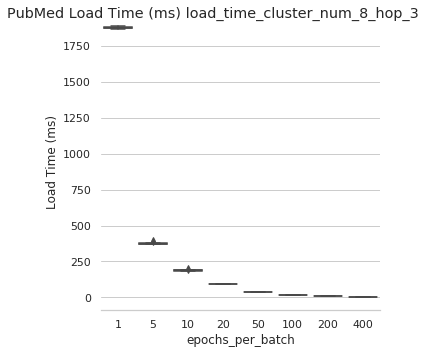

In [18]:
# tuning the mini_epoch
output_tune_param(data, data_name, dataset, image_data_path, intermediate_data_folder, partition_nums, layers, \
                  dropout = 0.3, lr = 0.0001, weight_decay = 0.001, mini_epoch_num = 20, valid_part_num = 2, mini_cluster_num = 16, round_num = 2)

#### Checking training loss

Start checking train loss for partition num: 2 hop layer: 1

Start to generate the clustering machine:
Batch machine creation costs a total of 0.1375 seconds!

 Information about the content of ./tmp/

Start to split data into train, test, validation:
Data splitting costs a total of 0.2193 seconds!
Start to store the batch machine file:
Storing batch machine after training batches generation costs a total of 0.0316 seconds!


Batch machine reading costs a total of 0.0377 seconds!
Start to generate the training batches:
Train batches production costs a total of 0.2791 seconds!

 Information about the content of ./train/
File name: [ batch_1 ]; with size: 19725.1982421875 KB
File name: [ batch_3 ]; with size: 19663.1279296875 KB
File name: [ batch_0 ]; with size: 19650.9248046875 KB
File name: [ batch_2 ]; with size: 19716.8076171875 KB


Batch machine reading costs a total of 0.0898 seconds!
Start to generate the validation batches:
Validation batches production costs a total of 0.2783 

Data splitting costs a total of 0.1725 seconds!
Start to store the batch machine file:
Storing batch machine after training batches generation costs a total of 0.0410 seconds!


Batch machine reading costs a total of 0.0511 seconds!
Start to generate the training batches:
Train batches production costs a total of 0.1993 seconds!

 Information about the content of ./train/
File name: [ batch_1 ]; with size: 9728.0263671875 KB
File name: [ batch_7 ]; with size: 9748.1826171875 KB
File name: [ batch_3 ]; with size: 9770.3232421875 KB
File name: [ batch_4 ]; with size: 9764.9169921875 KB
File name: [ batch_6 ]; with size: 9793.9404296875 KB
File name: [ batch_0 ]; with size: 9759.6201171875 KB
File name: [ batch_5 ]; with size: 9719.7919921875 KB
File name: [ batch_2 ]; with size: 9769.1748046875 KB


Batch machine reading costs a total of 0.0873 seconds!
Start to generate the validation batches:
Validation batches production costs a total of 0.2051 seconds!

 Information about the content

Train batches production costs a total of 0.1914 seconds!

 Information about the content of ./train/
File name: [ batch_9 ]; with size: 4798.5947265625 KB
File name: [ batch_1 ]; with size: 4816.2822265625 KB
File name: [ batch_15 ]; with size: 4922.5322265625 KB
File name: [ batch_8 ]; with size: 4830.8056640625 KB
File name: [ batch_13 ]; with size: 4894.0166015625 KB
File name: [ batch_11 ]; with size: 4820.5478515625 KB
File name: [ batch_7 ]; with size: 4874.3291015625 KB
File name: [ batch_3 ]; with size: 4852.4384765625 KB
File name: [ batch_4 ]; with size: 4820.8212890625 KB
File name: [ batch_6 ]; with size: 4857.3994140625 KB
File name: [ batch_0 ]; with size: 4888.4697265625 KB
File name: [ batch_5 ]; with size: 4862.3525390625 KB
File name: [ batch_14 ]; with size: 4848.5869140625 KB
File name: [ batch_10 ]; with size: 4904.8369140625 KB
File name: [ batch_2 ]; with size: 4890.8603515625 KB
File name: [ batch_12 ]; with size: 4840.9072265625 KB


Batch machine reading cost

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

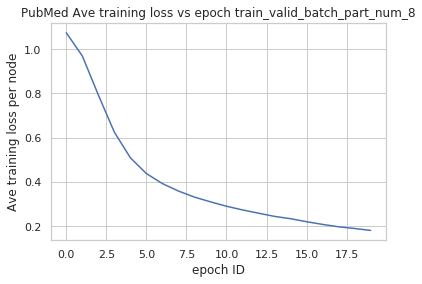

In [19]:
# check training loss
output_train_loss(data, data_name, dataset, image_data_path, intermediate_data_folder, partition_nums, layers, \
                  dropout = 0.3, lr = 0.0001, weight_decay = 0.001, mini_epoch_num = 20, valid_part_num = 2, mini_cluster_num = 16, round_num = 2)


### Check in_train performance

Start running for partition num: 2 hop layer 1

Start to generate the clustering machine:
Batch machine creation costs a total of 0.1688 seconds!

 Information about the content of ./tmp/

Start to split data into train, test, validation:
Data splitting costs a total of 0.1724 seconds!
Start to store the batch machine file:
Storing batch machine after training batches generation costs a total of 0.0408 seconds!


Batch machine reading costs a total of 0.0509 seconds!
Start to generate the training batches:
Train batches production costs a total of 0.2789 seconds!

 Information about the content of ./train/
File name: [ batch_1 ]; with size: 19690.0966796875 KB
File name: [ batch_3 ]; with size: 19648.7373046875 KB
File name: [ batch_0 ]; with size: 19679.9638671875 KB
File name: [ batch_2 ]; with size: 19730.8544921875 KB


Batch machine reading costs a total of 0.0735 seconds!
Start to generate the validation batches:
Validation batches production costs a total of 0.2870 seconds!

 In

Validation batches production costs a total of 0.2047 seconds!

 Information about the content of ./validation/
File name: [ batch_1 ]; with size: 9758.2685546875 KB
File name: [ batch_7 ]; with size: 9859.0107421875 KB
File name: [ batch_3 ]; with size: 9752.5810546875 KB
File name: [ batch_4 ]; with size: 9726.1044921875 KB
File name: [ batch_6 ]; with size: 9763.6748046875 KB
File name: [ batch_0 ]; with size: 9871.5732421875 KB
File name: [ batch_5 ]; with size: 9796.5498046875 KB
File name: [ batch_2 ]; with size: 9763.5732421875 KB

In-process Training costs a total of 3.4271 seconds!
In-process Training costs a total of 3.4667 seconds!
In-process Training costs a total of 3.4751 seconds!
In-process Training costs a total of 3.4419 seconds!
In-process Training costs a total of 3.4311 seconds!
In-process Training costs a total of 3.4395 seconds!
In-process Training costs a total of 3.4216 seconds!
Start running for partition num: 4 hop layer 2

Start to generate the clustering mac

/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Start running for partition num: 4 hop layer 3

Start to generate the clustering machine:
Batch machine creation costs a total of 0.2004 seconds!

 Information about the content of ./tmp/

Start to split data into train, test, validation:
Data splitting costs a total of 0.1748 seconds!
Start to store the batch machine file:
Storing batch machine after training batches generation costs a total of 0.0424 seconds!


Batch machine reading costs a total of 0.0524 seconds!
Start to generate the training batches:
Train batches production costs a total of 0.3463 seconds!

 Information about the content of ./train/
File name: [ batch_1 ]; with size: 9801.6201171875 KB
File name: [ batch_7 ]; with size: 9839.9248046875 KB
File name: [ batch_3 ]; with size: 9725.0419921875 KB
File name: [ batch_4 ]; with size: 9706.6591796875 KB
File name: [ batch_6 ]; with size: 9785.5029296875 KB
File name: [ batch_0 ]; with size: 9764.4013671875 KB
File name: [ batch_5 ]; with size: 9700.6201171875 KB
File nam

/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotli

Start running for partition num: 8 hop layer 1

Start to generate the clustering machine:
Batch machine creation costs a total of 0.1708 seconds!

 Information about the content of ./tmp/

Start to split data into train, test, validation:
Data splitting costs a total of 0.1734 seconds!
Start to store the batch machine file:
Storing batch machine after training batches generation costs a total of 0.0420 seconds!


Batch machine reading costs a total of 0.0513 seconds!
Start to generate the training batches:
Train batches production costs a total of 0.1896 seconds!

 Information about the content of ./train/
File name: [ batch_9 ]; with size: 4874.6025390625 KB
File name: [ batch_1 ]; with size: 4797.9462890625 KB
File name: [ batch_15 ]; with size: 4840.9228515625 KB
File name: [ batch_8 ]; with size: 4948.5322265625 KB
File name: [ batch_13 ]; with size: 4832.6259765625 KB
File name: [ batch_11 ]; with size: 4919.2978515625 KB
File name: [ batch_7 ]; with size: 4867.3212890625 KB
File 

/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotli

Start running for partition num: 8 hop layer 2

Start to generate the clustering machine:
Batch machine creation costs a total of 0.1324 seconds!

 Information about the content of ./tmp/

Start to split data into train, test, validation:
Data splitting costs a total of 0.2228 seconds!
Start to store the batch machine file:
Storing batch machine after training batches generation costs a total of 0.0417 seconds!


Batch machine reading costs a total of 0.0515 seconds!
Start to generate the training batches:
Train batches production costs a total of 0.1947 seconds!

 Information about the content of ./train/
File name: [ batch_9 ]; with size: 4847.5791015625 KB
File name: [ batch_1 ]; with size: 4864.7275390625 KB
File name: [ batch_15 ]; with size: 4840.6337890625 KB
File name: [ batch_8 ]; with size: 4925.0009765625 KB
File name: [ batch_13 ]; with size: 4897.9306640625 KB
File name: [ batch_11 ]; with size: 4826.8447265625 KB
File name: [ batch_7 ]; with size: 4861.1650390625 KB
File 

/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotli

Start running for partition num: 8 hop layer 3

Start to generate the clustering machine:
Batch machine creation costs a total of 0.1667 seconds!

 Information about the content of ./tmp/

Start to split data into train, test, validation:
Data splitting costs a total of 0.1726 seconds!
Start to store the batch machine file:
Storing batch machine after training batches generation costs a total of 0.0413 seconds!


Batch machine reading costs a total of 0.0512 seconds!
Start to generate the training batches:
Train batches production costs a total of 0.1974 seconds!

 Information about the content of ./train/
File name: [ batch_9 ]; with size: 4820.5478515625 KB
File name: [ batch_1 ]; with size: 4805.9462890625 KB
File name: [ batch_15 ]; with size: 4862.4697265625 KB
File name: [ batch_8 ]; with size: 4789.2509765625 KB
File name: [ batch_13 ]; with size: 4840.9072265625 KB
File name: [ batch_11 ]; with size: 4824.5712890625 KB
File name: [ batch_7 ]; with size: 4852.4384765625 KB
File 

/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotli

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

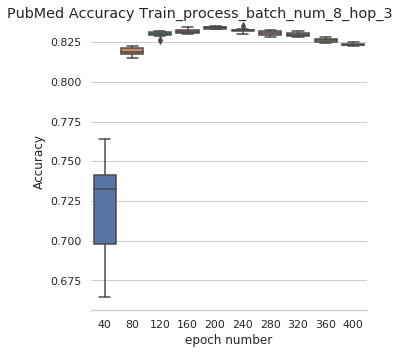

In [20]:

output_train_investigate(data, data_name, dataset, image_data_path, intermediate_data_folder, partition_nums, layers, \
                         dropout = 0.1, lr = 0.0001, weight_decay = 0.001, mini_epoch_num = 20, output_period = 40, \
                         valid_part_num = 2, mini_cluster_num = 16, round_num = 2)

### Output_F1

In [ ]:
# check F1-score
output_F1_score(data, data_name, dataset, image_data_path, intermediate_data_folder, partition_nums, layers, \
                dropout = 0.1, lr = 0.0001, weight_decay = 0.1, mini_epoch_num = 20, \
                valid_part_num = 2, mini_cluster_num = 16, round_num = 2)
        

Start running for partition num: 2 hop layer 1

Start to generate the clustering machine:
Batch machine creation costs a total of 0.2043 seconds!

 Information about the content of ./tmp/

Start to split data into train, test, validation:
Data splitting costs a total of 0.2018 seconds!
Start to store the batch machine file:
Storing batch machine after training batches generation costs a total of 0.4779 seconds!


Batch machine reading costs a total of 0.6452 seconds!
Start to generate the training batches:
Train batches production costs a total of 9.3198 seconds!

 Information about the content of ./train/
File name: [ batch_1 ]; with size: 340926.7939453125 KB
File name: [ batch_3 ]; with size: 333775.9501953125 KB
File name: [ batch_0 ]; with size: 333725.5419921875 KB
File name: [ batch_2 ]; with size: 340877.2626953125 KB


Batch machine reading costs a total of 0.6858 seconds!
Start to generate the validation batches:
Validation batches production costs a total of 13.5641 seconds!

/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib

Start running for partition num: 4 hop layer 1

Start to generate the clustering machine:
Batch machine creation costs a total of 0.1977 seconds!

 Information about the content of ./tmp/

Start to split data into train, test, validation:
Data splitting costs a total of 0.1990 seconds!
Start to store the batch machine file:
Storing batch machine after training batches generation costs a total of 0.4736 seconds!


Batch machine reading costs a total of 0.6358 seconds!
Start to generate the training batches:
Train batches production costs a total of 9.2232 seconds!

 Information about the content of ./train/
File name: [ batch_1 ]; with size: 169564.0498046875 KB
File name: [ batch_7 ]; with size: 166857.8232421875 KB
File name: [ batch_3 ]; with size: 168966.3388671875 KB
File name: [ batch_4 ]; with size: 170308.2763671875 KB
File name: [ batch_6 ]; with size: 166525.6279296875 KB
File name: [ batch_0 ]; with size: 169245.2216796875 KB
File name: [ batch_5 ]; with size: 170498.50292968

/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotli

Start running for partition num: 4 hop layer 2

Start to generate the clustering machine:
Batch machine creation costs a total of 0.1941 seconds!

 Information about the content of ./tmp/

Start to split data into train, test, validation:
Data splitting costs a total of 0.2521 seconds!
Start to store the batch machine file:
Storing batch machine after training batches generation costs a total of 0.4782 seconds!


Batch machine reading costs a total of 0.6453 seconds!
Start to generate the training batches:
Train batches production costs a total of 9.1729 seconds!

 Information about the content of ./train/
File name: [ batch_1 ]; with size: 164102.7685546875 KB
File name: [ batch_7 ]; with size: 167215.8310546875 KB
File name: [ batch_3 ]; with size: 169806.1435546875 KB
File name: [ batch_4 ]; with size: 167249.1748046875 KB
File name: [ batch_6 ]; with size: 169521.3623046875 KB
File name: [ batch_0 ]; with size: 169393.1279296875 KB
File name: [ batch_5 ]; with size: 170202.67480468

/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotli

Start running for partition num: 4 hop layer 3

Start to generate the clustering machine:
Batch machine creation costs a total of 0.2038 seconds!

 Information about the content of ./tmp/

Start to split data into train, test, validation:
Data splitting costs a total of 0.1992 seconds!
Start to store the batch machine file:
Storing batch machine after training batches generation costs a total of 0.4771 seconds!


Batch machine reading costs a total of 0.6451 seconds!
Start to generate the training batches:
Train batches production costs a total of 9.3861 seconds!

 Information about the content of ./train/
File name: [ batch_1 ]; with size: 167441.2763671875 KB
File name: [ batch_7 ]; with size: 167286.0185546875 KB
File name: [ batch_3 ]; with size: 167418.0654296875 KB
File name: [ batch_4 ]; with size: 166409.0263671875 KB
File name: [ batch_6 ]; with size: 173090.0888671875 KB
File name: [ batch_0 ]; with size: 171512.2373046875 KB
File name: [ batch_5 ]; with size: 167405.62792968

/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotli

Start running for partition num: 8 hop layer 1

Start to generate the clustering machine:
Batch machine creation costs a total of 0.2065 seconds!

 Information about the content of ./tmp/

Start to split data into train, test, validation:
Data splitting costs a total of 0.1968 seconds!
Start to store the batch machine file:
Storing batch machine after training batches generation costs a total of 0.4691 seconds!


Batch machine reading costs a total of 0.6365 seconds!
Start to generate the training batches:
Train batches production costs a total of 9.3090 seconds!

 Information about the content of ./train/
File name: [ batch_9 ]; with size: 86009.0322265625 KB
File name: [ batch_1 ]; with size: 84894.5087890625 KB
File name: [ batch_15 ]; with size: 84686.9697265625 KB
File name: [ batch_8 ]; with size: 83118.1650390625 KB
File name: [ batch_13 ]; with size: 83862.3994140625 KB
File name: [ batch_11 ]; with size: 84824.6337890625 KB
File name: [ batch_7 ]; with size: 81784.6650390625 K

/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotli

Start running for partition num: 8 hop layer 2

Start to generate the clustering machine:
Batch machine creation costs a total of 0.1595 seconds!

 Information about the content of ./tmp/

Start to split data into train, test, validation:
Data splitting costs a total of 0.2472 seconds!
Start to store the batch machine file:
Storing batch machine after training batches generation costs a total of 0.4716 seconds!


Batch machine reading costs a total of 0.6380 seconds!
Start to generate the training batches:
Train batches production costs a total of 9.1947 seconds!

 Information about the content of ./train/
File name: [ batch_9 ]; with size: 84756.6572265625 KB
File name: [ batch_1 ]; with size: 83520.9150390625 KB
File name: [ batch_15 ]; with size: 86767.8369140625 KB
File name: [ batch_8 ]; with size: 84237.5634765625 KB
File name: [ batch_13 ]; with size: 83520.9150390625 KB
File name: [ batch_11 ]; with size: 82297.0791015625 KB
File name: [ batch_7 ]; with size: 86771.8056640625 K

### CoraFull dataset

In [ ]:
from torch_geometric.datasets import CoraFull
data_name = 'CoraFull'
dataset = CoraFull(root = local_data_root + 'CoralFull')
print('number of data: ', len(dataset))
data = dataset[0]

image_data_path = './results/' + data_name + '/' + test_folder_name
intermediate_data_folder = './intermediate_data/' + data_name + '/' + test_folder_name

partition_nums = [4]
layers = [[128, 128]]


In [ ]:
# tune the parameter

output_tune_param(data, data_name, dataset, image_data_path, intermediate_data_folder, partition_nums, layers, \
                  dropout = 0.5, lr = 0.0001, weight_decay = 0.001, mini_epoch_num = 20, valid_part_num = 2)

# in-train process
# output_train_investigate(data, data_name, dataset, image_data_path, intermediate_data_folder, partition_nums, layers, \
#                          dropout = 0.5, lr = 0.0001, weight_decay = 0.001, mini_epoch_num = 20, output_period = 40, valid_part_num = 2)

In [ ]:
# # check F1-score
# output_F1_score(data, data_name, dataset, image_data_path, intermediate_data_folder, partition_nums, layers, \
#                 dropout = 0.1, lr = 0.0001, weight_decay = 0.1, mini_epoch_num = 20, valid_part_num = 2)

### CiteSeer Dataset

In [ ]:
from torch_geometric.datasets import Planetoid
data_name = 'CiteSeer'
dataset = Planetoid(root = local_data_root + 'Planetoid/CiteSeer', name=data_name)
data = dataset[0]
image_data_path = './results/' + data_name + '/' + test_folder_name

partition_nums = [2, 4, 8]
layers = [[], [16], [16, 16]]

### Tuning the epoch number per batch

#### Checking train loss

### PubMed dataset

In [ ]:
from torch_geometric.datasets import Planetoid
data_name = 'PubMed'
dataset = Planetoid(root = local_data_root + 'Planetoid/PubMed', name=data_name)
data = dataset[0]
image_data_path = './results/' + data_name + '/' + test_folder_name

partition_nums = [2, 4, 8]
layers = [[], [64], [64, 64], [64, 64, 64]]

#### Tune epoch number per batch

### Check the train error

### Appendix

In [ ]:
# free GPU memory
# !(nvidia-smi | grep 'python' | awk '{ print $3 }' | xargs -n1 kill -9)